In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from datetime import datetime, timedelta
from sqlalchemy import create_engine, Table, MetaData
from urllib.parse import quote_plus

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

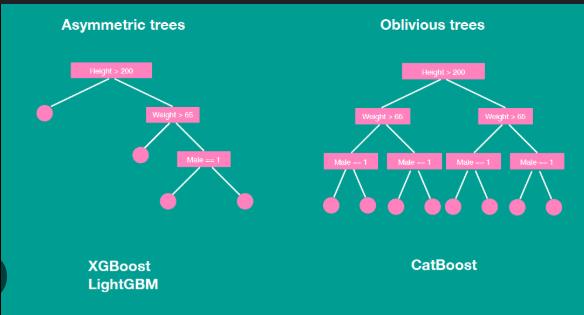

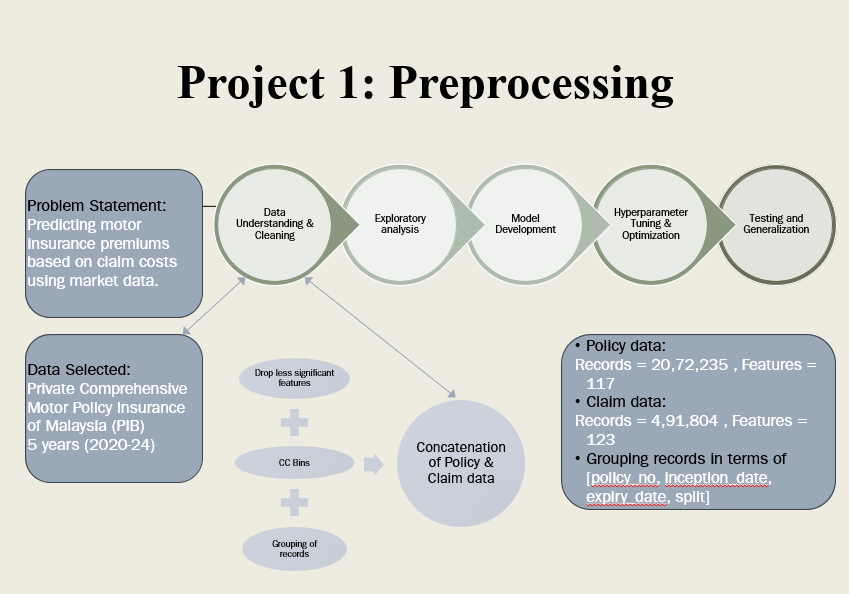

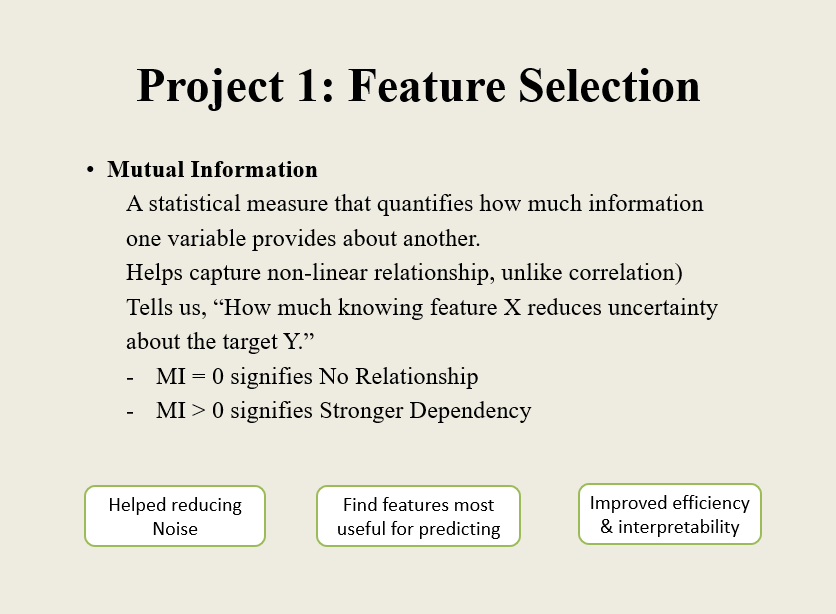 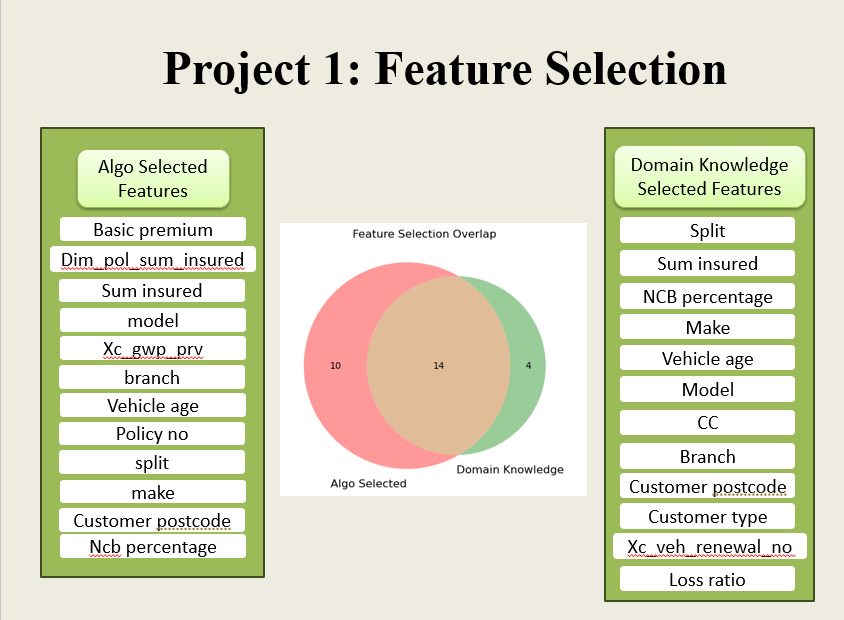

In [7]:
# --- MAIN EXECUTION ---
query ="""SELECT 
        p.policy_no,
        p.inception_date_new,
        p.expiry_date,
        p.split,
        p.sum_insured,
        p.branch,
        p.cust_type,
        p.cust_post_code,
        p.cust_gender,
        p.cust_age,
        p.vehicle_age,
        p.make,
        p.model,
        p.cc,
        p.cust_state,
        p.xc_veh_renewal_no,
        p.ncb_perc,
        p.pref_segment,
        0::numeric AS GWP,
        SUM(p.gic) AS GIC,
        SUM(p.noc_total) AS noc_total
    FROM ads.fct_mot_clm p
    LEFT JOIN ADS.MST_CONTRACT_TYPE c1
        ON p.CONTRACT_TYPE = c1.CONTRACT_TYPE_CODE
    INNER JOIN (
        SELECT * 
        FROM ADS.CTL_CALENDAR 
        WHERE CALENDAR_DT = (
            SELECT MAX(CALENDAR_DT) 
            FROM ADS.CTL_CALENDAR 
            WHERE STATUS = 'SUCCESS'
        )
    ) c ON TO_CHAR(p.uw_date, 'YYYY')::INTEGER >= c.AC_YEAR_CUR - 4
    WHERE 
        c1.CONTRACT_TYPE_LONG_DESC ILIKE '%PRIVATE CAR%' AND 
        p.cover = 'CO'
    GROUP BY 
        p.policy_no,
        p.inception_date_new,
        p.expiry_date,
        p.split,
        p.sum_insured,
        p.branch,
        p.cust_type,
        p.cust_post_code,
        p.cust_gender,
        p.cust_age,
        p.vehicle_age,
        p.make,
        p.model,
        p.cc,
        p.cust_state,
        p.xc_veh_renewal_no,
        p.ncb_perc,
        p.pref_segment
    
    UNION ALL

    SELECT 
        p.policy_no,
        p.inception_date_final,
        p.expiry_date,
        p.split,
        p.sum_insured,
        p.branch,
        p.cust_type,
        p.cust_post_code,
        p.cust_gender,
        p.cust_age,
        p.vehicle_age,
        p.make,
        p.model,
        p.cc,
        p.cust_state,
        p.xc_veh_renewal_no,
        p.ncb_perc,
        p.pref_segment,
        SUM(p.gwp) AS GWP,
        0::numeric AS GIC,
        0::numeric AS noc_total
    FROM ads.fct_mot_pol p
    LEFT JOIN ADS.MST_CONTRACT_TYPE c1
        ON p.CONTRACT_TYPE = c1.CONTRACT_TYPE_CODE
    INNER JOIN (
        SELECT * 
        FROM ADS.CTL_CALENDAR 
        WHERE CALENDAR_DT = (
            SELECT MAX(CALENDAR_DT) 
            FROM ADS.CTL_CALENDAR 
            WHERE STATUS = 'SUCCESS'
        )
    ) c ON TO_CHAR(p.uw_date, 'YYYY')::INTEGER >= c.AC_YEAR_CUR - 4
    WHERE 
        c1.CONTRACT_TYPE_LONG_DESC ILIKE '%PRIVATE CAR%' AND 
        p.cover = 'CO'
    GROUP BY 
        p.policy_no,
        p.inception_date_final,
        p.expiry_date,
        p.split,
        p.sum_insured,
        p.branch,
        p.cust_type,
        p.cust_post_code,
        p.cust_gender,
        p.cust_age,
        p.vehicle_age,
        p.make,
        p.model,
        p.cc,
        p.cust_state,
        p.xc_veh_renewal_no,
        p.ncb_perc,
        p.pref_segment;
;"""
# --- DB CONNECTION ---
try:
    connection = psycopg2.connect(
        host = "172.16.10.212",
        dbname = "PIB_PRD",
        user = "usr_app_pdi",
        password = 'Usr@ppPd!#123',
        port = "5432"
    )
    print("Connected to the database")

    cursor = connection.cursor()
    dff = pd.read_sql_query(query, connection)
    print("DataFrame Fetched Successfully!")
    print(dff.head())

except Exception as e:
    print("Error: Unable to connect to the database")
    print(e)


# finally:
#     # Close the cursor and connection
#     if cursor:
#         cursor.close()
#     if connection:
#         connection.close()

Connected to the database


C:\Users\ananya.datta\AppData\Local\Temp\ipykernel_14604\1213474750.py:130: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dff = pd.read_sql_query(query, connection)


DataFrame Fetched Successfully!
  policy_no inception_date_new expiry_date   split  sum_insured branch  \
0  V0115010         2021-01-16  2022-01-15  NONACT       7000.0     A1   
1  V0160338         2023-06-19  2024-06-18  NONACT       7100.0     H2   
2  V0164787         2021-08-28  2022-08-27  NONACT      15600.0     W1   
3  V0186345         2022-05-16  2023-05-15     ACT       7000.0     P1   
4  V0186345         2022-05-16  2023-05-15  NONACT       7000.0     P1   

  cust_type cust_post_code cust_gender  cust_age  ...     make   model  \
0         P          31400           M      53.0  ...   PROTON    WAJA   
1         P          70300           F      48.0  ...  PERODUA  KELISA   
2         P          52100           F      57.0  ...   TOYOTA    VIOS   
3         P          11950           M      58.0  ...   PROTON    WIRA   
4         P          11950           M      58.0  ...   PROTON    WIRA   

       cc  cust_state xc_veh_renewal_no  ncb_perc  pref_segment  gwp      gic 

In [3]:
# dff.to_csv('POLNCLAIM_11-06.csv',index=False)
dff = pd.read_csv(r'C:\Users\ananya.datta\OneDrive - Fairfax Asia Ltd\Desktop\Project 1 - Predictive Premium Pricing Modelling\Notebooks.py\POLNCLAIM_11-06.csv')
dff.shape

(1498435, 21)

In [4]:
dff.inception_date_new.value_counts()

inception_date_new
2022-11-30    3106
2022-12-30    2795
2022-09-30    2755
2023-02-28    2667
2022-04-28    2550
              ... 
2025-12-23       2
2025-12-25       2
2025-08-20       2
2025-10-01       2
2025-10-22       2
Name: count, Length: 1688, dtype: int64

In [18]:
dff[dff['expiry_date'] >= '2024-01-01']['expiry_date'].value_counts().sort_index()
count = (dff['expiry_date'] >= '2024-23-31').sum()
print(f'policies/claims records ending before 2025: {dff.shape[0]-count}')
print(f'policies/claims records ending in & after 2025: {count}')

policies/claims records ending before 2025: 1231489
policies/claims records ending in & after 2025: 266946


In [19]:
count = (dff['inception_date_new'] >= '2024-23-31').sum()
print(f'policies/claims records starting before 2025: {dff.shape[0]-count}')
print(f'policies/claims records starting in & after 2025: {count}')

policies/claims records starting before 2025: 1427027
policies/claims records starting in & after 2025: 71408


In [5]:
pd.set_option('display.max_columns', None)
mapp = pd.read_csv(r'C:\Users\ananya.datta\OneDrive - Fairfax Asia Ltd\Desktop\Project 1 - Predictive Premium Pricing Modelling\MST_BRANCH.csv')
# claim_data = pd.read_csv(r'C:\Users\ananya.datta\OneDrive - Fairfax Asia Ltd\Desktop\Project 1 - Predictive Premium Pricing Modelling\New folder\New folder\CLM_DATA(for ML).csv')
# policy_data = pd.read_csv(r'C:\Users\ananya.datta\OneDrive - Fairfax Asia Ltd\Desktop\Project 1 - Predictive Premium Pricing Modelling\du\du\POL_DATA(for ML).csv')

In [24]:
# pol_col = ['policy_no', 'inception_date_final', 'expiry_date', 'split','sum_insured', 'branch', 'cust_type',
#     'cust_post_code', 'cust_state', 'cust_gender', 'cust_age', 'vehicle_age',
#     'make', 'model', 'cc', 'xc_veh_renewal_no', 'ncb_perc', 'pref_segment']

# claim_data.rename(columns = {'inception_date_new':'inception_date_final'}, inplace = True)
# pdata = policy_data[pol_col + ['gwp']]
# cdata = claim_data[pol_col + ['gic', 'noc_total']]
# combined = pd.concat([pdata, cdata], ignore_index=True)

In [25]:
# grouped_data = combined.groupby(['policy_no','inception_date_final','expiry_date','split']).agg({
#     'gwp': 'sum',          
#     'sum_insured': 'sum',  
#     'gic': 'sum',          
#     'noc_total': 'sum',    
#     'branch': 'first',     
#     'cust_type': 'first',  
#     'cust_post_code': 'first',  
#     'cust_state': 'first', 
#     'cust_gender': 'first', 
#     'cust_age': 'first',   
#     'vehicle_age': 'first', 
#     'make': 'first',      
#     'model': 'first',      
#     'cc': 'first',         
#     'xc_veh_renewal_no': 'first', 
#     'ncb_perc': 'first',  
#     'pref_segment': 'first' }).reset_index()
# grouped_data.dropna(subset = ['cc', 'cust_post_code','make'], inplace=True)

In [15]:
grouped_data['inception_date_final'] = pd.to_datetime(grouped_data['inception_date_final'])

# Filter data for inception_date_final from 2021 onwards and before 2025
filtered_data = grouped_data[(grouped_data['inception_date_final'].dt.year >= 2021) &
                             (grouped_data['inception_date_final'].dt.year < 2025)]

# Calculate the sums for 'gwp', 'gic', and 'noc_total' after filtering
print(f'gwp sum (from 2021 to 2024): {filtered_data.gwp.sum()}')
print(f'gic sum (from 2021 to 2024): {filtered_data.gic.sum()}')
print(f'noc_total sum (from 2021 to 2024): {filtered_data.noc_total.sum()}')
print(grouped_data.shape)

gwp sum (from 2021 to 2024): 494865986.1399999
gic sum (from 2021 to 2024): 319191749.26000005
noc_total sum (from 2021 to 2024): 50199.0
(1593620, 21)


In [16]:
print("Min date:", grouped_data['inception_date_final'].min())
print("Max date:", grouped_data['inception_date_final'].max())

Min date: 2020-01-01 00:00:00
Max date: 2024-12-31 00:00:00


In [6]:
df = dff.copy()
print(df.columns)
# df['inception_date_new'] = pd.to_datetime(df['inception_date_new'])
# df['expiry_date'] = pd.to_datetime(df['expiry_date'])

# Filter data for inception_date_final from 2021 onwards and before 2025
filtered_data = df[(df['inception_date_new']>='2021-01-01') &
                             (df['inception_date_new']<'2025-04-31')]

# Calculate the sums for 'gwp', 'gic', and 'noc_total' after filtering
print(f'gwp sum (from 2021 to 2025-04-31): {filtered_data.gwp.sum()}')
print(f'gic sum (from 2021 to 2025-04-31): {filtered_data.gic.sum()}')
print(f'noc_total sum (from 2021 to 2025-04-31): {filtered_data.noc_total.sum()}')
print(f'(1): {df.shape}')
print(f'(1.1 from 2021 to 2025-04-31): {filtered_data.shape}')

Index(['policy_no', 'inception_date_new', 'expiry_date', 'split',
       'sum_insured', 'branch', 'cust_type', 'cust_post_code', 'cust_gender',
       'cust_age', 'vehicle_age', 'make', 'model', 'cc', 'cust_state',
       'xc_veh_renewal_no', 'ncb_perc', 'pref_segment', 'gwp', 'gic',
       'noc_total'],
      dtype='object')
gwp sum (from 2021 to 2025-04-31): 533842542.1100001
gic sum (from 2021 to 2025-04-31): 356089277.01000005
noc_total sum (from 2021 to 2025-04-31): 54062.0
(1): (1498435, 21)
(1.1 from 2021 to 2025-04-31): (1478799, 21)


- Training the model from 2021 to April 2025
- Test the model & predict from May 2025
- testing data shape -- 19,636 records
- training data shape -- 1,478,799 records

In [7]:
print("Min date:", df['inception_date_new'].min())
print("Max date:", df['inception_date_new'].max())

Min date: 2021-01-01
Max date: 2025-12-30


In [8]:
df.head()     

,policy_no,inception_date_new,expiry_date,split,sum_insured,branch,cust_type,cust_post_code,cust_gender,cust_age,vehicle_age,make,model,cc,cust_state,xc_veh_renewal_no,ncb_perc,pref_segment,gwp,gic,noc_total
0,V0115010,2021-01-16,2022-01-15,NONACT,7000.0,A1,P,31400.0,M,53.0,20.0,PROTON,WAJA,1584.0,MAL,7,55.00,0,0.0,3439.60,1.0
1,V0160338,2023-06-19,2024-06-18,NONACT,7100.0,H2,P,70300.0,F,48.0,21.0,PERODUA,KELISA,989.0,MAL,9,55.00,0,0.0,1443.83,1.0
2,V0164787,2021-08-28,2022-08-27,NONACT,15600.0,W1,P,52100.0,F,57.0,17.0,TOYOTA,VIOS,1496.0,MAL,7,38.33,0,0.0,889.00,1.0
3,V0186345,2022-05-16,2023-05-15,ACT,7000.0,P1,P,11950.0,M,58.0,21.0,PROTON,WIRA,1468.0,MAL,8,55.00,0,0.0,8417.00,1.0
4,V0186345,2022-05-16,2023-05-15,NONACT,7000.0,P1,P,11950.0,M,58.0,21.0,PROTON,WIRA,1468.0,MAL,8,55.00,0,0.0,4410.27,1.0


In [9]:
df.isnull().sum()

policy_no                  0
inception_date_new         0
expiry_date                2
split                      0
sum_insured                0
branch                     0
cust_type                  0
cust_post_code            34
cust_gender           100753
cust_age              100894
vehicle_age                0
make                    8518
model                  11428
cc                         0
cust_state                 0
xc_veh_renewal_no          0
ncb_perc                   0
pref_segment               0
gwp                        0
gic                        0
noc_total                  0
dtype: int64

In [10]:
df = df.groupby(['policy_no','inception_date_new','expiry_date','split']).agg({
    'gwp': 'sum',          
    'sum_insured': 'sum',  
    'gic': 'sum',          
    'noc_total': 'sum',    
    'branch': 'first',     
    'cust_type': 'first',  
    'cust_post_code': 'first',  
    'cust_state': 'first', 
    'cust_gender': 'first', 
    'cust_age': 'first',   
    'vehicle_age': 'first', 
    'make': 'first',      
    'model': 'first',      
    'cc': 'first',         
    'xc_veh_renewal_no': 'first', 
    'ncb_perc': 'first',  
    'pref_segment': 'first' }).reset_index()
print(f'(2): {df.shape}')
df.isnull().sum()

(2): (1359200, 21)


policy_no                 0
inception_date_new        0
expiry_date               0
split                     0
gwp                       0
sum_insured               0
gic                       0
noc_total                 0
branch                    0
cust_type                 0
cust_post_code           30
cust_state                0
cust_gender           87816
cust_age              87942
vehicle_age               0
make                   7541
model                 10135
cc                        0
xc_veh_renewal_no         0
ncb_perc                  0
pref_segment              0
dtype: int64

In [11]:
def categorize_cc(f):
    # Define the bins and labels
    bins = [0, 1000, 1500, 2000, 3000, 4000, np.inf]
    labels = ['0-1000', '1000-1500', '1500-2000', '2000-3000', '3000-4000', '4000+']
    
    # Apply the categorization to the 'cc' column using pd.cut
    f['cc'] = pd.cut(f['cc'], bins=bins, labels=labels, right=False)
    
    return f
    
def process_cust_age(f, lowerb=20, upperb=80):
    # Cap and floor bounds for 'cust_age'
    f['cust_age'] = f['cust_age'].apply(lambda x: max(min(x, upperb), lowerb))
    
    # Fill the missing values with the sampled values
    missing_indices = f[f['cust_age'].isnull()].index
    non_missing_values = f['cust_age'].dropna()  # Get non-null values
    random_samples = np.random.choice(non_missing_values, size=len(missing_indices), replace=True)
    f.loc[missing_indices, 'cust_age'] = random_samples
    return f

def process_cust_gender(f):
     # Calculate the proportions of 'M' and 'F' in the entire dataset
    gender_counts = f['cust_gender'].value_counts(normalize=True)
    prob_m = gender_counts.get('M', 0)  # Proportion of 'M'
    prob_f = gender_counts.get('F', 0)  # Proportion of 'F'
    # Make sure the probabilities sum to 1
    total_prob = prob_m + prob_f
    if total_prob != 1:
        prob_m /= total_prob
        prob_f /= total_prob
    # Define the imputation function
    def fill_gender(row):
        if pd.isna(row['cust_gender']):
            # Sample a gender based on the overall proportions
            return np.random.choice(['M', 'F'], p=[prob_m, prob_f])
        return row['cust_gender']
    f['cust_gender'] = f.apply(fill_gender, axis=1)
    return f

def process_model(f, top_n=10):
    # Get the top N most frequent models
    model_distribution = f['model'].dropna().value_counts()
    top_n_models = model_distribution.head(top_n)
    model_proportions = top_n_models / top_n_models.sum()
    # Generate a list of model values to fill in the missing 'model' entries, proportionally
    missing_indices = f[f['model'].isnull()].index
    # Sample from the top N models using the calculated proportions
    fill_values = np.random.choice(top_n_models.index, size=len(missing_indices), p=model_proportions)
    # Fill the missing values in the 'model' column
    f.loc[missing_indices, 'model'] = fill_values

    return f

def process_make(f, top_n=10):
    # Get the top N most frequent models
    make_distribution = f['make'].dropna().value_counts()
    top_n_make = make_distribution.head(top_n)
    make_proportions = top_n_make / top_n_make.sum()
    # Generate a list of model values to fill in the missing 'model' entries, proportionally
    missing_indices = f[f['make'].isnull()].index
    # Sample from the top N models using the calculated proportions
    fill_values = np.random.choice(top_n_make.index, size=len(missing_indices), p=make_proportions)
    # Fill the missing values in the 'model' column
    f.loc[missing_indices, 'make'] = fill_values

    return f

def process_postcode(f, top_n=10):
    # Get the top N most frequent models
    postcode_distribution = f['cust_post_code'].dropna().value_counts()
    top_n_postcode = postcode_distribution.head(top_n)
    postcode_proportions = top_n_postcode / top_n_postcode.sum()
    # Generate a list of model values to fill in the missing 'model' entries, proportionally
    missing_indices = f[f['cust_post_code'].isnull()].index
    # Sample from the top N models using the calculated proportions
    fill_values = np.random.choice(top_n_postcode.index, size=len(missing_indices), p=postcode_proportions)
    # Fill the missing values in the 'model' column
    f.loc[missing_indices, 'cust_post_code'] = fill_values

    return f

def process_lossratio(f):
    # Calculate the 'loss_ratio' column
    f['loss_ratio'] = f.apply(lambda row: 'not there' if row['gic'] == 0 and row['gwp'] == 0 
                              else 0 if row['gic'] == 0 
                              else 'not defined' if row['gwp'] == 0 
                              else row['gic'] / row['gwp'], axis=1)
    
    # Remove rows where 'loss_ratio' is 'not there' or 'not defined'
    f = f[~f['loss_ratio'].isin(['not there', 'not defined'])]
    return f

In [12]:
missing_records = df[df[['expiry_date', 'cust_post_code', 'make', 'cc']].isna().any(axis=1)]
missing_records

,policy_no,inception_date_new,expiry_date,split,gwp,sum_insured,gic,noc_total,branch,cust_type,cust_post_code,cust_state,cust_gender,cust_age,vehicle_age,make,model,cc,xc_veh_renewal_no,ncb_perc,pref_segment
7286,V0596825,2022-12-15,2023-12-14,NONACT,1953.07,163066.0,0.0,0.0,H5,P,50480.0,MAL,M,47.0,0.0,None,None,5204.0,0,55.0,2
7326,V0596887,2023-04-19,2024-04-18,NONACT,1880.88,54425.0,0.0,0.0,H5,P,14100.0,MAL,M,57.0,4.0,None,None,4395.0,0,0.0,0
7327,V0596887,2024-04-19,2025-04-18,NONACT,1447.90,51268.0,0.0,0.0,H5,P,14100.0,MAL,M,58.0,5.0,None,None,4395.0,1,25.0,0
7388,V0596960,2023-03-17,2024-03-16,NONACT,2640.76,135000.0,0.0,0.0,H5,C,93350.0,MAL,None,NaN,1.0,None,None,3444.0,0,25.0,0
7389,V0596960,2024-03-17,2025-03-16,NONACT,1914.29,135000.0,0.0,0.0,H5,C,93350.0,MAL,None,NaN,2.0,None,None,3444.0,1,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359107,V7357657,2025-06-10,2026-06-09,NONACT,2301.59,90000.0,0.0,0.0,B2,P,55100.0,MAL,M,38.0,3.0,None,None,658.0,0,0.0,0
1359124,V7357762,2025-07-18,2026-07-17,ACT,728.07,462000.0,0.0,0.0,J1,P,81560.0,MAL,M,49.0,2.0,None,None,2999.0,0,30.0,0
1359125,V7357762,2025-07-18,2026-07-17,NONACT,9883.93,462000.0,0.0,0.0,J1,P,81560.0,MAL,M,49.0,2.0,None,None,2999.0,0,30.0,0
1359144,V7357835,2025-07-05,2026-07-04,ACT,197.63,34000.0,0.0,0.0,P3,P,8000.0,MAL,M,51.0,19.0,None,None,3497.0,0,55.0,0


In [13]:
df = process_cust_age(df)
df = process_cust_gender(df)
df = process_model(df)
df = process_make(df)
df = process_postcode(df)
df = process_lossratio(df)
df = categorize_cc(df)
# df = df.dropna(subset = ['cc', 'cust_post_code','make'])

In [14]:
print(f'(3): {df.shape}')
df.isnull().sum()

(3): (1333378, 22)


policy_no             0
inception_date_new    0
expiry_date           0
split                 0
gwp                   0
sum_insured           0
gic                   0
noc_total             0
branch                0
cust_type             0
cust_post_code        0
cust_state            0
cust_gender           0
cust_age              0
vehicle_age           0
make                  0
model                 0
cc                    0
xc_veh_renewal_no     0
ncb_perc              0
pref_segment          0
loss_ratio            0
dtype: int64

In [15]:
def initial_preprocess(df):
    if not np.issubdtype(df['inception_date_new'].dtype, np.datetime64):
        df['inception_date_new'] = pd.to_datetime(df['inception_date_new'])
    df['inception_year'] = df['inception_date_new'].dt.year
    weights = df['loss_ratio'].apply(lambda x: 100 if x > 0.75 else 1)
    df['loss_ratio'] = df['loss_ratio'].astype('int64')
    df = df[df['branch'] != 'H5']
    return df, weights

def extract_date_parts(df):
    df['inception_month'] = df['inception_date_new'].dt.month
    df['inception_year'] = df['inception_date_new'].dt.year
    df = df.sort_values('inception_date_new')
    return df

def preserve_original(df, cols):
    return df[cols].copy()

def drop_unnecessary_columns(df, cols_to_drop):
    return df.drop(cols_to_drop, axis=1)

def convert_dtypes_for_catboost(df, convert_float_to_int=True):
    df["inception_year"] = df["inception_year"].astype('int64')
    df["inception_month"] = df["inception_month"].astype('int64')
    df["cc"] = df["cc"].astype('object')
    return df 

def prepare_data(df, preserve_cols, drop_cols, convert_float_to_int=True):
    preserved_df = preserve_original(df, preserve_cols)
    df = drop_unnecessary_columns(df, drop_cols)
    df = convert_dtypes_for_catboost(df, convert_float_to_int=convert_float_to_int)
    return df, preserved_df

In [16]:
# Apply preprocessing
i, weights = initial_preprocess(df)

preserve_cols = ['policy_no', 'inception_date_new', 'expiry_date', 'noc_total']
drop_cols = ['policy_no', 'inception_date_new', 'expiry_date', 'noc_total']
cutoff = pd.to_datetime('2025-04-30')

trg1 = i[i['inception_date_new'] <= cutoff] # Training data
tst1 = i[i['inception_date_new'] > cutoff] # Testing beyond May 2025

# Apply date part extraction
trg1 = extract_date_parts(trg1)
tst1 = extract_date_parts(tst1)

C:\Users\ananya.datta\AppData\Local\Temp\ipykernel_15572\3512076412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inception_month'] = df['inception_date_new'].dt.month
C:\Users\ananya.datta\AppData\Local\Temp\ipykernel_15572\3512076412.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inception_year'] = df['inception_date_new'].dt.year
C:\Users\ananya.datta\AppData\Local\Temp\ipykernel_15572\3512076412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [17]:
print(f'trg1 (2021-23)(4): {trg1.shape}')
print(f'tst1 (2024)(5): {tst1.shape}')

trg1 (2021-23)(4): (1312550, 24)
tst1 (2024)(5): (18926, 24)


In [18]:
trg1.columns

Index(['policy_no', 'inception_date_new', 'expiry_date', 'split', 'gwp',
       'sum_insured', 'gic', 'noc_total', 'branch', 'cust_type',
       'cust_post_code', 'cust_state', 'cust_gender', 'cust_age',
       'vehicle_age', 'make', 'model', 'cc', 'xc_veh_renewal_no', 'ncb_perc',
       'pref_segment', 'loss_ratio', 'inception_year', 'inception_month'],
      dtype='object')

In [19]:
trg1, trg1_og = prepare_data(trg1, preserve_cols, drop_cols)
tst1, tst1_og = prepare_data(tst1, preserve_cols, drop_cols)

In [20]:
def categorize_columns_for_catboost(df):
    num = []
    cat = []
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:  # For numerical columns
            num.append(column)
            if df[column].dtype == 'float64':  # Convert float to int
                df[column] = df[column].astype(np.int64)
        elif df[column].dtype == 'object':  # For categorical columns (string type)
            cat.append(column)
    
    return num, cat

numerical,categorical = categorize_columns_for_catboost(trg1)
numerical.pop(0)

'gwp'

In [21]:
len(categorical)

8

In [22]:
# Function to compute evaluation metrics
def evaluate_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, mae, mse, rmse

def train_evaluate_model(X, y, weights, tscv, cat_features, best_model):
    # Store the performance metrics for each fold
    fold_metrics = []
    r2_scores = []
    mae_scores = []
    mse_scores = []
    rmse_scores = []

    # Loop through the splits and train the model
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Extract weights for the current fold's training data
        train_weights = weights.iloc[train_index]

        # Rearrange columns so that 'loss_ratio' comes first in the feature order
        columns = ['loss_ratio'] + [col for col in X_train.columns if col != 'loss_ratio']
        X_train = X_train[columns]
        X_test = X_test[columns]

        # Fit the model with early stopping
        best_model.fit(
            X_train, y_train,
            eval_set=(X_test, y_test),
            early_stopping_rounds=100,
            verbose=100,
            cat_features=cat_features,
            sample_weight=train_weights
        )

        # Make predictions and evaluate the model
        y_pred = best_model.predict(X_test)
        r2, mae, mse, rmse = evaluate_model(y_test, y_pred)

        # Store fold-wise metrics
        r2_scores.append(r2)
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)

        # Optionally store detailed fold metrics
        fold_metrics.append({
            'fold': fold + 1,
            'r2': r2,
            'mae': mae,
            'mse': mse,
            'rmse': rmse
        })

    return fold_metrics, r2_scores, mae_scores, mse_scores, rmse_scores

In [23]:
# TRAINING
# Define the target and features
X = trg1[numerical + categorical]
y = trg1['gwp']

# Set up TimeSeriesSplit (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Define the CatBoost model
best_model = CatBoostRegressor(
    iterations=900, 
    depth=8, 
    learning_rate=0.01, 
    l2_leaf_reg=70, 
    verbose=100,
    random_seed=42, 
    early_stopping_rounds=50
)

# Explicitly set categorical columns
cat_features = [X.columns.get_loc(col) for col in categorical]

# Train and evaluate the model
fold_metrics, r2_scores, mae_scores, mse_scores, rmse_scores = train_evaluate_model(
    X, y, weights, tscv, cat_features, best_model
)

# Compute average metrics across all folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)

# Print the fold-wise metrics
print("Fold-wise metrics:")
for fold_metric in fold_metrics:
    print(f"Fold {fold_metric['fold']}: R2 = {fold_metric['r2']}, MAE = {fold_metric['mae']}, MSE = {fold_metric['mse']}, RMSE = {fold_metric['rmse']}")

# Print the average evaluation metrics
print(f"\nAverage R2: {avg_r2}")
print(f"Average MAE: {avg_mae}")
print(f"Average MSE: {avg_mse}")
print(f"Average RMSE: {avg_rmse}")

0:	learn: 552.0728092	test: 485.9429644	best: 485.9429644 (0)	total: 609ms	remaining: 9m 7s
100:	learn: 362.2115862	test: 305.7139057	best: 305.7139057 (100)	total: 29s	remaining: 3m 49s
200:	learn: 294.1898476	test: 258.9367853	best: 258.9367853 (200)	total: 1m 3s	remaining: 3m 40s
300:	learn: 253.6004687	test: 237.6151759	best: 237.6151759 (300)	total: 1m 35s	remaining: 3m 10s
400:	learn: 226.9604286	test: 226.3396271	best: 226.3396271 (400)	total: 2m 11s	remaining: 2m 43s
500:	learn: 205.8749031	test: 218.2734115	best: 218.2734115 (500)	total: 2m 38s	remaining: 2m 6s
600:	learn: 187.8929362	test: 210.8793499	best: 210.8793499 (600)	total: 3m 4s	remaining: 1m 31s
700:	learn: 173.8421749	test: 205.2589266	best: 205.2589266 (700)	total: 3m 33s	remaining: 1m
800:	learn: 162.2380500	test: 200.1623422	best: 200.1623422 (800)	total: 4m 2s	remaining: 30s
899:	learn: 152.4324355	test: 196.5269735	best: 196.5269735 (899)	total: 4m 31s	remaining: 0us

bestTest = 196.5269735
bestIteration = 899

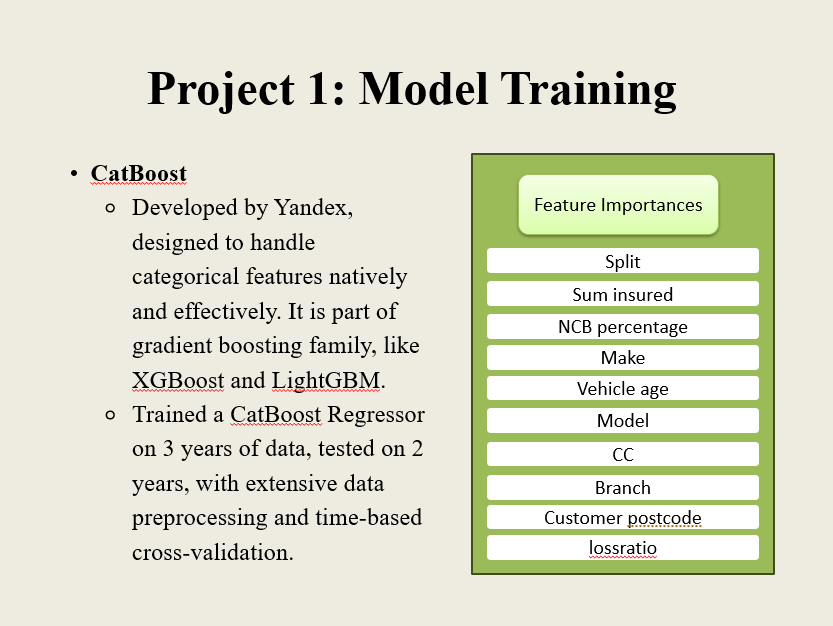 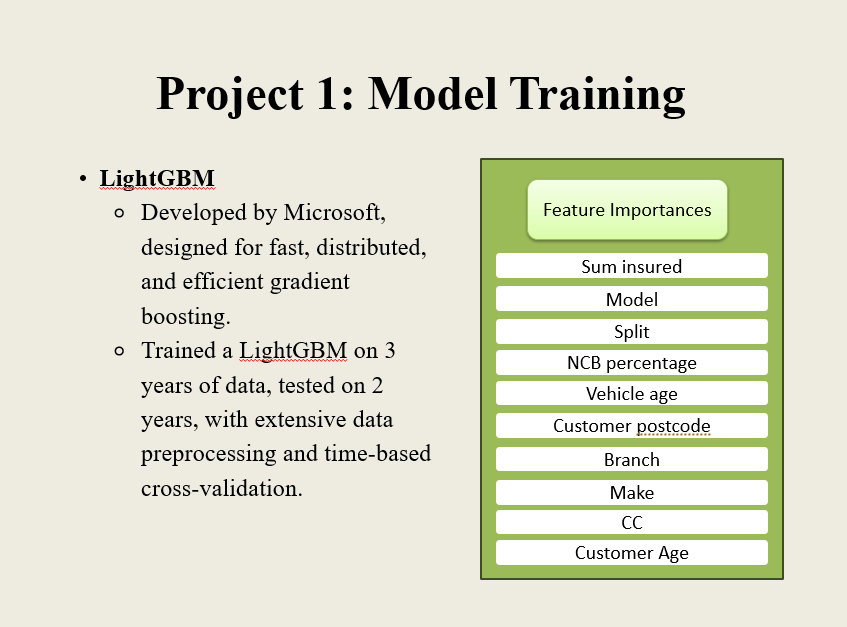 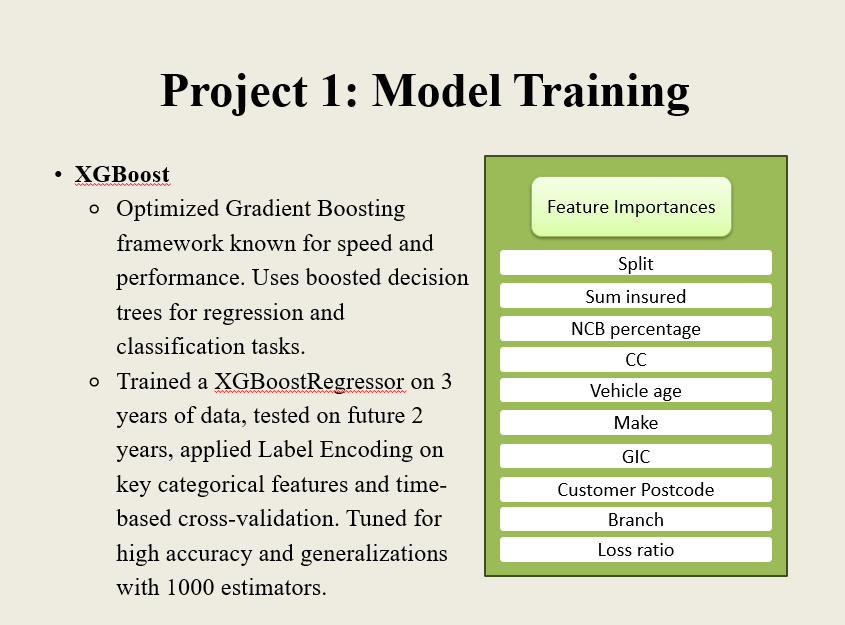
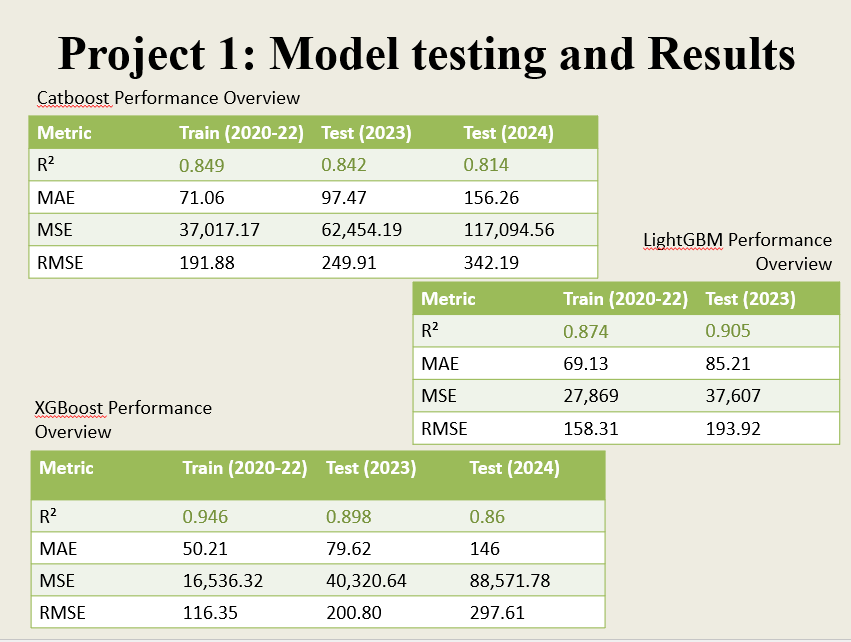

In [24]:
best_model.save_model('catboostRegressorfinal') 
best_model.load_model('catboostRegressorfinal')

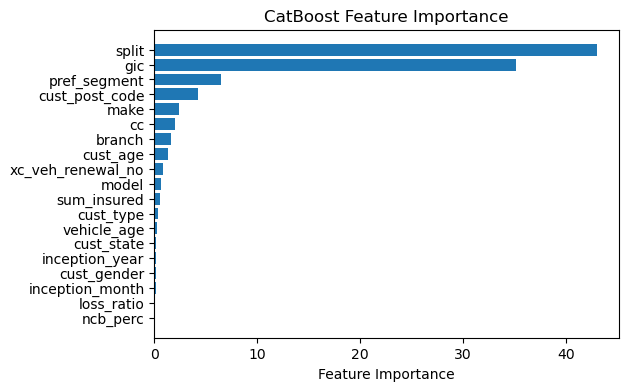

In [25]:
# Get feature importance from the CatBoost model
feature_importances = best_model.get_feature_importance()

# Create a list of feature names (numerical + categorical)
feature_names = numerical + categorical

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(6,4))
plt.barh(range(len(feature_names)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [26]:
def predict_and_merge(model, df, df_og, numerical_columns, categorical_columns, target_col='gwp'):
    # Prepare the features (X) and target (y)
    X = df[numerical_columns + categorical_columns]
    y = df[target_col]

    # Make predictions
    y_pred = model.predict(X)

    # Assign the predicted values to the dataframe
    df = df.assign(predicted_gwp=y_pred)

    # Convert 'inception_date_final' to object type in the original dataframe
    df_og['inception_date_new'] = df_og['inception_date_new'].astype('object')

    # Merge the original dataframe with the predictions
    df = df_og.merge(df, left_index=True, right_index=True, how='left')

    # Convert 'inception_date_final' back to datetime format
    df['inception_date_new'] = pd.to_datetime(df['inception_date_new']).dt.date

    return df

# Apply the function to tst1 and tst2
tst1 = predict_and_merge(best_model, tst1, tst1_og, numerical, categorical)

In [27]:
# Define the target and features
XXt = tst1[numerical + categorical]
yyt = tst1['gwp']
y_preddt = best_model.predict(XXt)
# Evaluate the model on the test data
r2_test1 = r2_score(yyt, y_preddt)
mae_test1 = mean_absolute_error(yyt, y_preddt)
mse_test1 = mean_squared_error(yyt, y_preddt)
rmse_test1 = np.sqrt(mse_test1)

# Print test evaluation metrics
print(f"Test R2: {r2_test1}")
print(f"Test MAE: {mae_test1}")
print(f"Test MSE: {mse_test1}")
print(f"Test RMSE: {rmse_test1}")

# Optionally, you can also calculate adjusted R-squared for the test data
nt_test1 = len(yyt)  # Number of samples in the test set
pt_test1 = XXt.shape[1]  # Number of features in the test set

# Adjusted R-squared formula
r2_adj_test1 = 1 - ((1 - r2_test1) * (nt_test1 - 1)) / (nt_test1 - pt_test1 - 1)

print(f"Adjusted Test R2: {r2_adj_test1}")

Test R2: 0.8892902360802561
Test MAE: 152.6330263577826
Test MSE: 90191.1059852748
Test RMSE: 300.31834107372595
Adjusted Test R2: 0.8891789758710911


In [28]:
tst1.head()

,policy_no,inception_date_new,expiry_date,noc_total,split,gwp,sum_insured,gic,branch,cust_type,cust_post_code,cust_state,cust_gender,cust_age,vehicle_age,make,model,cc,xc_veh_renewal_no,ncb_perc,pref_segment,loss_ratio,inception_year,inception_month,predicted_gwp
1346385,V7317873,2025-05-01,2026-04-30,0.0,NONACT,420.52,12000.0,0.0,A4,P,47100.0,MAL,F,44.0,11.0,PROTON,SAGA,1000-1500,0,55.0,0,0,2025,5,213.647260
1346055,V7316818,2025-05-01,2026-04-30,0.0,ACT,223.67,28200.0,0.0,B1,P,31450.0,MAL,F,58.0,4.0,PERODUA,AXIA,0-1000,0,55.0,0,0,2025,5,202.574242
1346056,V7316818,2025-05-01,2026-04-30,0.0,NONACT,519.71,28200.0,0.0,B1,P,31450.0,MAL,F,58.0,4.0,PERODUA,AXIA,0-1000,0,55.0,0,0,2025,5,414.364615
1348960,V7326331,2025-05-01,2026-04-30,0.0,ACT,272.70,27100.0,0.0,N3,P,71000.0,MAL,F,52.0,11.0,TOYOTA,VIOS,1000-1500,7,55.0,0,0,2025,5,198.424342
1346384,V7317873,2025-05-01,2026-04-30,0.0,ACT,170.63,12000.0,0.0,A4,P,47100.0,MAL,F,44.0,11.0,PROTON,SAGA,1000-1500,0,55.0,0,0,2025,5,138.273373


In [32]:
trg1.head()

,split,gwp,sum_insured,gic,branch,cust_type,cust_post_code,cust_state,cust_gender,cust_age,vehicle_age,make,model,cc,xc_veh_renewal_no,ncb_perc,pref_segment,loss_ratio,inception_year,inception_month
79191,ACT,150,11000,0,W8,P,34300,MAL,F,26,13,PROTON,PERSONA,1500-2000,2,55,0,0,2021,1
59253,NONACT,241,7000,0,N3,P,43000,MAL,F,40,18,PERODUA,KANCIL,0-1000,5,55,0,0,2021,1
59252,ACT,157,7000,0,N3,P,43000,MAL,F,40,18,PERODUA,KANCIL,0-1000,5,55,0,0,2021,1
235325,NONACT,228,7000,0,J1,P,34250,MAL,M,49,21,PROTON,WIRA,1000-1500,0,55,0,0,2021,1
150025,NONACT,1445,162000,1500,J1,P,82000,MAL,M,27,4,TOYOTA,HILUX,2000-3000,2,55,0,1,2021,1
